<a href="https://colab.research.google.com/github/susmita-dutta-cs/GreyScale-Image-Colorization/blob/main/GreyScaleImageTransformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/image"


In [ ]:
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
import os

path, dirs, files = next(os.walk("/content/drive/MyDrive/image/train"))
file_count = len(files)
print(file_count)

1007


In [ ]:
#Normalize images - divide by 255 rescale images by diving the pixel ( each pixel of each channel are divided by 255 to get a value from 0 to 1)
#the activation function goes from 0 to 1 relu 
train_data= ImageDataGenerator(rescale=1. / 255)

In [ ]:
#Resize images, if needed
path ="/content/drive/MyDrive/image"
train = train_data.flow_from_directory(path, 
                                          target_size=(128,128), 
                                          batch_size=1007, 
                                          class_mode=None)

Found 1007 images belonging to 2 classes.


In [ ]:
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) # l channel
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, y means a and b channel.
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_prev = np.array(X)
Y= np.array(Y)
X = X_prev.reshape(X_prev.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)




(1007, 128, 128, 1)
(1007, 128, 128, 2)


In [ ]:
# print (X)

In [ ]:
# to check whether l channel is properly converted or not x values are taken into account
# the display issues are due to the range of Lab values which are: L (0-100), a (-128-127), b (-128-127).
# https://docs.opencv.org/3.3.0/de/d25/imgproc_color_conversions.html#color_convert_rgb_lab

image_lab_scaled = (X + [0, 128, 128]) / [100, 255, 255]


First 10 Images in the dataset:


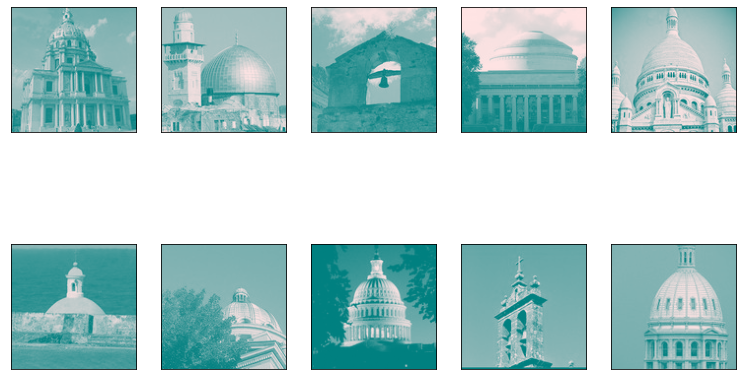

In [ ]:
print('First 10 Images in the dataset:')
fig = plt.figure(figsize=(13,8))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(image_lab_scaled[i]) # x_prev
   
    
plt.show()

In [ ]:
#Encoder

model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2, input_shape=(128, 128, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
#Decoder
#Note: For the last layer we use tanh instead of Relu. 
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1. 
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse' , metrics=['accuracy'])
model.summary()
# rmsprop doesnt give ideal curve for the training and val loss graph
# adam does
# why so explain in the project

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 512)       1180160   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 512)       2

In [ ]:
history = model.fit(X,Y,validation_split=0.3, epochs=150, batch_size=32)

Epoch 1/150
22/22 [==============================] - 7s 129ms/step - loss: 0.2911 - accuracy: 0.5014 - val_loss: 0.0127 - val_accuracy: 0.6023
Epoch 2/150
22/22 [==============================] - 2s 94ms/step - loss: 0.0125 - accuracy: 0.5151 - val_loss: 0.0120 - val_accuracy: 0.5030
Epoch 3/150
22/22 [==============================] - 2s 94ms/step - loss: 0.0149 - accuracy: 0.4965 - val_loss: 0.0122 - val_accuracy: 0.5132
Epoch 4/150
22/22 [==============================] - 2s 94ms/step - loss: 0.0141 - accuracy: 0.5112 - val_loss: 0.0121 - val_accuracy: 0.5132
Epoch 5/150
22/22 [==============================] - 2s 94ms/step - loss: 0.0124 - accuracy: 0.4966 - val_loss: 0.0122 - val_accuracy: 0.5134
Epoch 6/150
22/22 [==============================] - 2s 95ms/step - loss: 0.0129 - accuracy: 0.5047 - val_loss: 0.0121 - val_accuracy: 0.5189
Epoch 7/150
22/22 [==============================] - 2s 94ms/step - loss: 0.0129 - accuracy: 0.5113 - val_loss: 0.0120 - val_accuracy: 0.5134
Epoch

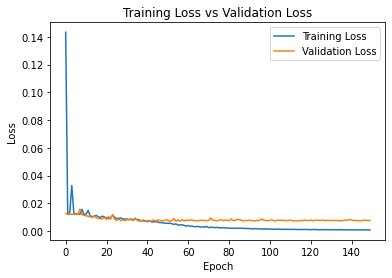

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model.save('colorize_autoencoder301.model')

INFO:tensorflow:Assets written to: colorize_autoencoder301.model/assets


In [ ]:
model_save_name = 'colorize_autoencoder301.model'
path = F"/content/drive/MyDrive/image/ouput/{model_save_name}" 
model.save(model_save_name, path)

INFO:tensorflow:Assets written to: colorize_autoencoder301.model/assets


In [ ]:
from google.colab import files

In [ ]:
value =files.upload()


In [ ]:
from skimage import img_as_ubyte
img1_color=[]
img1=img_to_array(load_img('dome_001.jpg'))
img1 = resize(img1 ,(128,128))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))
output1 = model.predict(img1_color)
output1 = output1*128
result = np.zeros((128,128, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
res= lab2rgb (result)
# imsave('result_bw.png',result)
imsave("result.png", res)

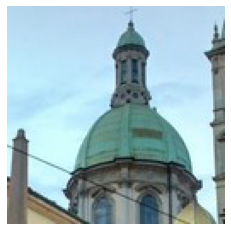

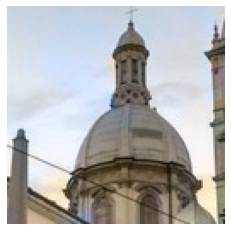

In [ ]:
from PIL import Image

#read the image
im_original = Image.open('dome_001.jpg')

plt.imshow(np.asarray(im_original))
plt.axis('off')
plt.show()

#show image
im_original.show()
plt.imshow(res) # show image
plt.axis('off') # does not display axes
plt.show()

In [ ]:
ref = cv2.imread('result.png')
img= cv2.imread('dome_001.jpg')
# ref = Image.open('path1').convert("RGB")
ref_array = np.array(ref)
print(ref_array.shape)    # (256, 256, 3)
# img = Image.open('path2').convert("RGB")
img_array = np.array(img)
print(img_array.shape)    # (256, 256, 3)

ssim = compare_ssim(ref_array, img_array, multichannel=True, data_range=255)
print("SSIM: {}".format(ssim))

(128, 128, 3)
(128, 128, 3)
SSIM: 0.9578449991511042


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.
